#Predicting Financial Impact of Car Part Delays

This notebook focuses on building a predictive model to estimate the financial impact caused by delays in car part deliveries within the automotive supply chain. By analyzing various factors such as supplier performance, part criticality, and transportation conditions, the model aims to provide accurate forecasts of potential financial losses.

## Step 1 : Importing Libraries

In [22]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import joblib

## Loading the Dataset

In [3]:
# Step 2: Load dataset
df = pd.read_csv("Financial_Impact_Regression_Final_Dataset (1).csv")

In [4]:
# Step 3: Basic overview
print("Shape of data:", df.shape)
df.head()

Shape of data: (1010, 79)


,Engine_Supplier_Region,Engine_Supplier_Reliability,Engine_Transport_Mode,Is_Critical_Engine,Transmission_Supplier_Region,Transmission_Supplier_Reliability,Transmission_Transport_Mode,Is_Critical_Transmission,Brake_System_Supplier_Region,Brake_System_Supplier_Reliability,...,Critical_Susp_x_Delay,Critical_Info_x_Delay,Urgency_x_TotalDelayed,Holiday_x_CriticalDelay,Strike_x_TotalDelayed,Weather_x_TotalDelayed,Is_Any_Part_Delayed,All_Parts_On_Time,All_Critical_Parts_On_Time,Financial_Impact_Log
0,EAST,0.76,ROAD,1,NORTH,0.79,ROAD,0,SOUTH,0.94,...,1,0,MEDIUMMEDIUMMEDIUM,0,0,STORMSTORMSTORM,1,0,0,7.824446
1,NORTH,0.75,SEA,1,EAST,0.98,AIR,1,EAST,0.99,...,0,0,MEDIUMMEDIUM,0,0,CLEARCLEAR,1,0,1,0.000000
2,WEST,0.74,AIR,0,EAST,0.95,AIR,1,EAST,0.85,...,0,0,NaN,0,0,NaN,0,1,1,0.000000
3,EAST,0.85,ROAD,0,EAST,0.92,ROAD,1,NORTH,0.76,...,0,1,HIGHHIGHHIGHHIGH,0,0,CLEARCLEARCLEARCLEAR,1,0,0,6.908755
4,SOUTH,0.79,AIR,0,SOUTH,0.79,AIR,0,NORTH,0.80,...,0,0,LOW,0,0,CLEAR,1,0,1,0.000000


## Quick Summary of Columns & Target

In [5]:
# Check data types and missing values
df.info()

# Summary of target variable
df['Financial_Impact_USD'].describe()

# Check how many 0s in target
print("Zero financial impact rows:", (df['Financial_Impact_USD'] == 0).sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010 entries, 0 to 1009
Data columns (total 79 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Engine_Supplier_Region             1010 non-null   object 
 1   Engine_Supplier_Reliability        1010 non-null   float64
 2   Engine_Transport_Mode              1010 non-null   object 
 3   Is_Critical_Engine                 1010 non-null   int64  
 4   Transmission_Supplier_Region       1010 non-null   object 
 5   Transmission_Supplier_Reliability  1010 non-null   float64
 6   Transmission_Transport_Mode        1010 non-null   object 
 7   Is_Critical_Transmission           1010 non-null   int64  
 8   Brake_System_Supplier_Region       1010 non-null   object 
 9   Brake_System_Supplier_Reliability  1010 non-null   float64
 10  Brake_System_Transport_Mode        1010 non-null   object 
 11  Is_Critical_Brake_System           1010 non-null   int64

## Visualize Target Distribution

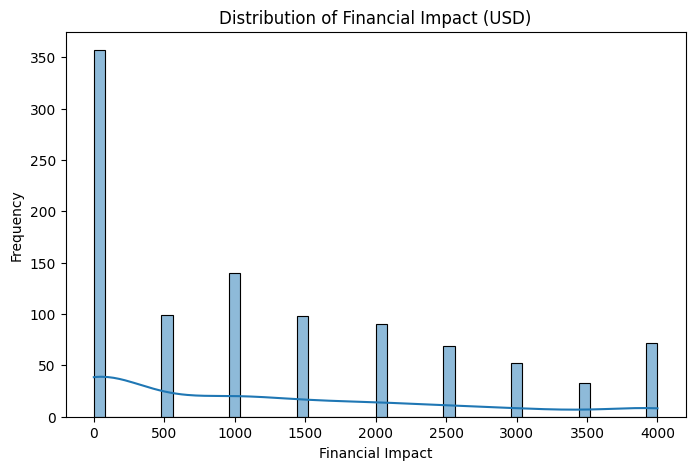

In [6]:
# Distribution of target
plt.figure(figsize=(8,5))
sns.histplot(df['Financial_Impact_USD'], bins=50, kde=True)
plt.title("Distribution of Financial Impact (USD)")
plt.xlabel("Financial Impact")
plt.ylabel("Frequency")
plt.show()

Shows skewness and confirms need for log transform due to right skew (heavy tail). We did the log transformation in the feature engineering notebook, as Finacial_Impact_Log Column.

## Handle Missing Values

In [7]:
# Check missing values
missing = df.isnull().sum()
missing[missing > 0].sort_values(ascending=False)

,0
Order_Urgency_Num,1010
Delay_Per_Urgency,1010
Urgency_x_TotalDelayed,20
Weather_x_TotalDelayed,20


In [8]:
# Drop completely empty columns
df.drop(columns=['Order_Urgency_Num', 'Delay_Per_Urgency'], inplace=True)


# Fill specific ratios with 0 (no delays = 0% ratio)
fill_zero_cols = ['Non_Critical_Parts_Delayed_Ratio', 'Urgency_x_TotalDelayed',
                  'Weather_x_TotalDelayed', 'Critical_Parts_Ratio']

df[fill_zero_cols] = df[fill_zero_cols].fillna(0)

In [9]:
# Confirm cleanup
print("Missing values after cleaning:\n", df.isnull().sum().sum())

Missing values after cleaning:
 0


## Define Target and Features

In [10]:
# Define target and input features
y = df['Financial_Impact_Log'] # Log-transformed target to reduce skewness
X = df.drop(columns=['Financial_Impact_USD', 'Financial_Impact_Log']) # Features

## Understand Feature Types

In [11]:
# Step: Classify columns properly
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("Categorical columns:\n", categorical_cols)
print("\nNumerical columns:\n", numerical_cols)

Categorical columns:
 ['Engine_Supplier_Region', 'Engine_Transport_Mode', 'Transmission_Supplier_Region', 'Transmission_Transport_Mode', 'Brake_System_Supplier_Region', 'Brake_System_Transport_Mode', 'Suspension_Supplier_Region', 'Suspension_Transport_Mode', 'Infotainment_Supplier_Region', 'Infotainment_Transport_Mode', 'Order_Urgency', 'Weather_Condition_On_Delivery', 'Production_Shift', 'Route_Type', 'Traffic_Level', 'Engine_Supplier_Group', 'Transmission_Supplier_Group', 'Brake_System_Supplier_Group', 'Suspension_Supplier_Group', 'Infotainment_Supplier_Group', 'Urgency_x_TotalDelayed', 'Weather_x_TotalDelayed']

Numerical columns:
 ['Engine_Supplier_Reliability', 'Is_Critical_Engine', 'Transmission_Supplier_Reliability', 'Is_Critical_Transmission', 'Brake_System_Supplier_Reliability', 'Is_Critical_Brake_System', 'Suspension_Supplier_Reliability', 'Is_Critical_Suspension', 'Infotainment_Supplier_Reliability', 'Is_Critical_Infotainment', 'Engine_Delayed_Flag', 'Transmission_Delayed_Fl

Categorical and numerical columns are treated differently during modeling. Tree-based models like CatBoost handle categoricals natively, while others may require encoding.

## Split the Dataset for Training and Testing

In [12]:
# Use 80% for training, 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)

Training data shape: (808, 75)
Testing data shape: (202, 75)


Train-Test Split Rationale:

80/20 split is standard.

random_state=42 ensures reproducibility.

##Categorical Encoding + Feature Scaling

In [13]:
# Encode categorical features using one-hot encoding
X_train_encoded = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)

# Align columns (ensure train & test have same feature set)
X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='left', axis=1, fill_value=0)

One-hot encoding is used here; drop_first=True avoids dummy variable trap. Aligning ensures test data has same columns as training.

In [14]:
# Standardize numerical features
scaler = StandardScaler()
X_train_encoded[numerical_cols] = scaler.fit_transform(X_train_encoded[numerical_cols])
X_test_encoded[numerical_cols] = scaler.transform(X_test_encoded[numerical_cols])

Why this is important:

- Prevents data leakage during encoding.

- Scaling improves convergence for some algorithms (like linear models).

- Aligning keeps feature sets consistent.

## Train Random Forest (All Features)

In [15]:
# Train model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_encoded, y_train)

# Predict
y_pred_log = rf_model.predict(X_test_encoded)

# Inverse transform predictions and true values from log scale back to USD scale
y_test_usd = np.expm1(y_test)
y_pred_usd = np.expm1(y_pred_log)

# Evaluate on USD scale
mae = mean_absolute_error(y_test_usd, y_pred_usd)
rmse = np.sqrt(mean_squared_error(y_test_usd, y_pred_usd))
r2 = r2_score(y_test_usd, y_pred_usd)

print(f"Random Forest MAE (USD): {mae:.2f}")
print(f"Random Forest RMSE (USD): {rmse:.2f}")
print(f"Random Forest R² Score: {r2:.4f}")


Random Forest MAE (USD): 448.79
Random Forest RMSE (USD): 675.10
Random Forest R² Score: 0.7222


Results:
MAE:- mean average prediction error is $449 USD on financial impact.

RMSE:- $675 indicates typical prediction error magnitude.

R²:-  0.72 means model explains 72% of variance, which is decent for real-world data.

This uses all features, which is good baseline, but later we will try to improve with feature selection.

## Visualize the Feature Importances

/tmp/ipython-input-16-1632118369.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_10, palette='viridis')


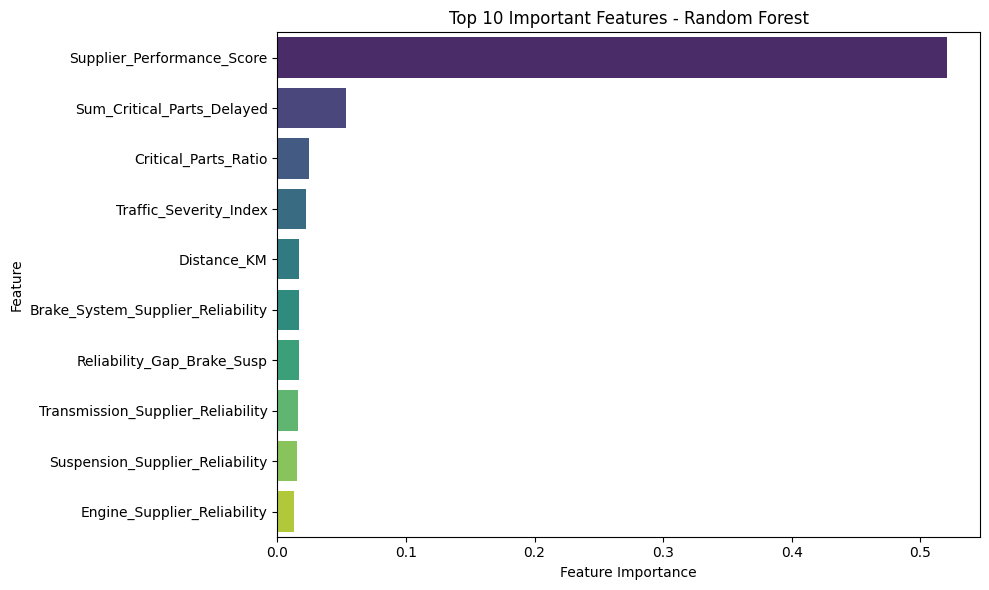

In [16]:
# Get feature importances and match with feature names
feature_importances = rf_model.feature_importances_
feature_names = X_train_encoded.columns

# Create a DataFrame for easier sorting and plotting
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort and select top 10
top_10 = importance_df.sort_values(by='Importance', ascending=False).head(10)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_10, palette='viridis')
plt.title('Top 10 Important Features - Random Forest')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

Plots top 10 features driving model predictions — helps decide which features to keep.

## Random Forest on Top 10 Features (All Numeric)

In [17]:
# Selecting top 10 features
top_10_features = ['Supplier_Performance_Score', 'Distance_KM', 'Brake_System_Supplier_Reliability',
    'Sum_Critical_Parts_Delayed', 'Engine_Supplier_Reliability', 'Traffic_Severity_Index',
    'Critical_Parts_Ratio', 'Reliability_Gap_Brake_Susp', 'Suspension_Supplier_Reliability',
    'Transmission_Supplier_Reliability']

# Analyzing Features And Target
X_top10 = df[top_10_features]
y = df['Financial_Impact_Log']

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X_top10, y, test_size=0.2, random_state=42)

# Scale numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Training Random Forest model
rf_top10 = RandomForestRegressor(n_estimators=100, random_state=42)
rf_top10.fit(X_train_scaled, y_train)

# Predict on test set (log scale)
y_pred_log = rf_top10.predict(X_test_scaled)

# Convert predictions and actuals back to USD
y_test_usd = np.expm1(y_test)
y_pred_usd = np.expm1(y_pred_log)

# Evaluation
mae = mean_absolute_error(y_test_usd, y_pred_usd)
rmse = np.sqrt(mean_squared_error(y_test_usd, y_pred_usd))
r2 = r2_score(y_test_usd, y_pred_usd)

print(f"Random Forest (Top 10 features) MAE (USD): {mae:.2f}")
print(f"Random Forest (Top 10 features) RMSE (USD): {rmse:.2f}")
print(f"Random Forest (Top 10 features) R² Score: {r2:.4f}")


Random Forest (Top 10 features) MAE (USD): 452.94
Random Forest (Top 10 features) RMSE (USD): 675.38
Random Forest (Top 10 features) R² Score: 0.7220


Results:

- MAE: $453 (slightly higher than full model)

- RMSE: $675 (similar)

- R²: 0.7220 (almost same)

Analysis:
Model performs nearly as well with just 10 features, indicating possible simplification.

## Random Forest on Top 5 Features (All Numeric)

In [21]:
# Selecting top 5 features
top_5_features = ['Supplier_Performance_Score', 'Distance_KM', 'Brake_System_Supplier_Reliability','Sum_Critical_Parts_Delayed', 'Engine_Supplier_Reliability']

# Analyzing Features And Target
X_top5 = df[top_5_features]
y = df['Financial_Impact_Log']

# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X_top5, y, test_size=0.2, random_state=42)

# Scale numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Training Random Forest model
rf_top5 = RandomForestRegressor(n_estimators=100, random_state=42)
rf_top5.fit(X_train_scaled, y_train)

# Predict on test set (log scale)
y_pred_log = rf_top5.predict(X_test_scaled)

# Convert predictions and actuals back to USD
y_test_usd = np.expm1(y_test)
y_pred_usd = np.expm1(y_pred_log)

# Evaluation
mae = mean_absolute_error(y_test_usd, y_pred_usd)
rmse = np.sqrt(mean_squared_error(y_test_usd, y_pred_usd))
r2 = r2_score(y_test_usd, y_pred_usd)

print(f"Random Forest (Top 5 features) MAE (USD): {mae:.2f}")
print(f"Random Forest (Top 5 features) RMSE (USD): {rmse:.2f}")
print(f"Random Forest (Top 5 features) R² Score: {r2:.4f}")


Random Forest (Top 5 features) MAE (USD): 445.52
Random Forest (Top 5 features) RMSE (USD): 664.21
Random Forest (Top 5 features) R² Score: 0.7311


Results:

- MAE: $445 (lowest error so far)

- RMSE: $664 (best RMSE)

- R²: 0.7311 (highest, best fit)

Analysis:
Top 5 features yield best balance of simplicity and accuracy — ideal for deployment.

## Random Forest on Top 3 Features (All Numeric)

In [20]:
# Selecting top 3 features
top_3_features = ['Supplier_Performance_Score', 'Distance_KM', 'Brake_System_Supplier_Reliability']

# Analyzing Features And Target
X_top3 = df[top_3_features]
y = df['Financial_Impact_Log']

# Train Test split
X_train, X_test, y_train, y_test = train_test_split(
    X_top3, y, test_size=0.2, random_state=42)

# Scale numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Training Random Forest model
rf_top3 = RandomForestRegressor(n_estimators=100, random_state=42)
rf_top3.fit(X_train_scaled, y_train)

# Predict on test set (log scale)
y_pred_log = rf_top3.predict(X_test_scaled)

# Convert predictions and actuals back to USD
y_test_usd = np.expm1(y_test)
y_pred_usd = np.expm1(y_pred_log)

# Evaluation
mae = mean_absolute_error(y_test_usd, y_pred_usd)
rmse = np.sqrt(mean_squared_error(y_test_usd, y_pred_usd))
r2 = r2_score(y_test_usd, y_pred_usd)

print(f"Random Forest (Top 3 features) MAE (USD): {mae:.2f}")
print(f"Random Forest (Top 3 features) RMSE (USD): {rmse:.2f}")
print(f"Random Forest (Top 3 features) R² Score: {r2:.4f}")

Random Forest (Top 3 features) MAE (USD): 462.39
Random Forest (Top 3 features) RMSE (USD): 686.96
Random Forest (Top 3 features) R² Score: 0.7124


Results:

- MAE: $462.39

- RMSE: $686.96

- R²: 0.7124

Analysis:
Performance drops slightly but still reasonable with just 3 features.

| Model                           | MAE (USD) | RMSE (USD) | R² Score |
|--------------------------------|-----------|------------|----------|
| Random Forest (All Features)    | 448.79    | 675.10     | 0.7222   |
| Random Forest (Top 10 Features) | 452.94    | 675.38     | 0.7220   |
| Random Forest (Top 5 Features)  | 445.52    | 664.21     | 0.7311   |
| Random Forest (Top 3 Features)  | 462.39    | 686.96     | 0.7124   |


The model with all features works well, but using just the top 10 features gives almost the same results. Using the top 5 features actually improves the model slightly. With only the top 3 features, the performance drops a bit. So, the best balance is the top 5 features — it’s simpler and even a bit more accurate.

In [24]:
# Your trained model
model_to_save = rf_top5

# List of features used
features_used = top_5_features

# Save model
joblib.dump(model_to_save, 'random_forest_top5_cost_model.pkl')

# Save features list
joblib.dump(features_used, 'random_forest_top5_cost_features.pkl')

print("Model saved as 'random_forest_top5_cost_model.pkl'")
print("Feature list saved as 'random_forest_top5_cost_features.pkl'")


Model saved as 'random_forest_top5_cost_model.pkl'
Feature list saved as 'random_forest_top5_cost_features.pkl'
